### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [9]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

VERBOSE = 1
CV = [(slice(None), slice(None))]
TESTING = False

ITER = 3

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [10]:
hyperparameterspace = {
    #'loss': ["list", 'mean_absolute_error', 'mean_squared_error'],
    'epochs': ["interval-int", 1, 10],
    'batch_size': ["interval-int", 40, 160],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [11]:
ids = [233214]#, 233211]#, 359935, 359952, 359940, 359931]#, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

valid_datasets = 0
for i in range(len(ids)):
    dataset = HPO.Dataset(task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(): 
        # create model
        model = Sequential()
        model.add(Dense(40, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
        model.add(Dense(40, activation=ACTIVATION_FUNCTION))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(40, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            model.add(Dense(40, activation=ACTIVATION_FUNCTION))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
            K.clear_session()
            return result 
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
            K.clear_session()
            return result
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = from_standard(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(40, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                model.add(Dense(40, activation=ACTIVATION_FUNCTION))
                model.add(Dense(1, activation=None))
                # Compile model
                
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer,)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
                K.clear_session()
                return result
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
                K.clear_session()
                return result
            


    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1)**3
        print("Current Budget:", BUDGET)

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = i

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        TESTING = True
        BAYESIAN_RESULT.append(-blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(BUDGET)
        SPARSE_COST_OPTIMIZED.append(BUDGET)

        K.clear_session()
    



Current Budget: 1
Performing grid search
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Performing random search
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Performing bayesian optimization
Iterations took 1.9528132720006397 seconds
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 39170ms.
Solving linear system (automatic method)...
Done in 2ms.

Optimal hyperparameters so far:
epochs: 7.75
batch_size: 70.0
optimizer__learning_rate: 0.005000050000000001
Resulting loss:
0.9173317419732496
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 9.999997105652287
batch_size: 40.00004288459038
optimizer__learning_rate: 1.0460803757853766e-07
Resulting loss (Optimal value from optimization):
-2.370286920872931
Resulting loss (Optimal point evaluated):
1.7190494239950282
Current Budget: 8
Performing grid search
Fitting 1 folds for each of 8 candidates, totalling 8 fits
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 27.655462167967926 seconds
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 43182ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 5.5
batch_size: 70.0
optimizer__learning_rate: 0.007500025000000001
Resulting loss:
0.8983074942857978
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 5.500000207885332
batch_size: 40.00007475735746
optimizer__learning_rate: 0.009999994495367724
Resulting loss (Optimal value from optimization):
-0.9199761831807625
Resulting loss (Optimal point evaluated):
0.9701399793711424
Current Budget: 27
Performing grid search
Fitting 1 folds for each of 27 candidates, totalling 27 fits
Performing random search
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Performing bayesian optimization
Iterations took 109.80345010502788 seconds
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 45947

[1, 8, 27]
[1, 8, 27]
[1, 8, 27]
[1, 8, 27]
[1, 8, 27]
[1.3544856, 1.159209, 1.8894947]
[1.1083932, 1.1448475, 1.0871075]
[1.0102805, 1.3233153, 1.1117468]
[1.0557504829193693, 0.958554352185212, 0.9872225448965785]
[2.440569917300838, 0.969822444704182, 1.8333504181429976]
Current dataset: 0 with name id: 233214


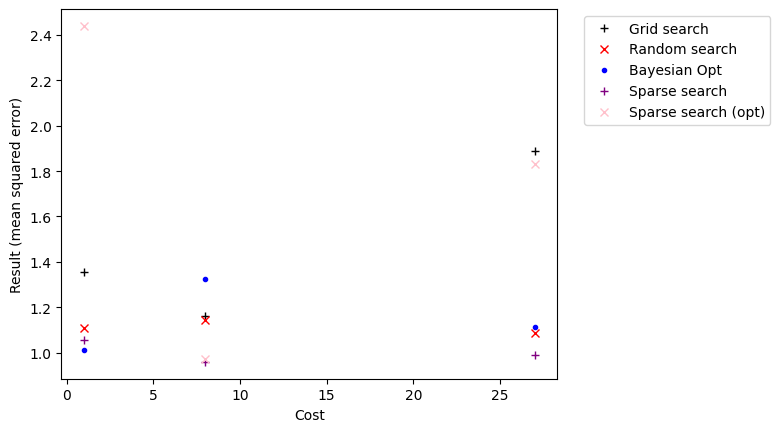

In [12]:
print(GRID_COST)
print(RANDOM_COST)
print(BAYESIAN_COST)
print(SPARSE_COST)
print(SPARSE_COST)
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

